
# 01_subclassing-bijectors

In [1]:
import numpy as np
!which python3

/usr/bin/python3


## 推导log_det_jacobian of sigmoid function

Bijector
Here: Sigmoid function - https://en.wikipedia.org/wiki/Sigmoid_function
<br>
$S(x) = \dfrac{1}{1+e^{-x}} = \dfrac{e^x}{e^x+1}$

Jacobian matrix - p201, [2020][4.3]Probabilistic Deep Learning - With Python, Keras and TensorFlow Probability[重要]
Here: Sigmoid function's derivative - https://towardsdatascience.com/derivative-of-the-sigmoid-function-536880cf918e
<br>
$S'(x) = S(x)(1-S(x))$

Since the event dimension is 1, the Jacobian matrix is a scalar, which is also its determinant. Therefore,
<br>
Logrithm of determinant of Jacobian matrix of sigmoid function as the bijector function
$log(|S'(x)|) = log(S(x)) + log(1-S(x)) = -log(e^{-x}+1)  - log(e^x+1)$
<br>
Note, Softplus function - https://en.wikipedia.org/wiki/Rectifier_(neural_networks)#Softplus
$softplus(x)=log(1+e^x)$
<br>
Therefore,
$log(|S'(x)|) = -softplus(-x)-softplus(x)$

至于inverse_log_det_jacobian，他与forward_log_det_jacobian的关系，详见：[202103]Building Probability Distributions with the TensorFlow Probability Bijector API _ Louis Tiao.pdf

# 02_coding-tutorial-subclassing-bijectors

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
import numpy as np
import matplotlib.pyplot as plt

gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

2022-05-05 13:59:54.729972: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 13:59:54.736340: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 13:59:54.736645: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [134]:
# from tensorflow_probability.python.internal import parameter_properties
# Define a new bijector: Cubic
class Cubic(tfb.Bijector):

    def __init__(self, a, b, validate_args=False, name='Cubic'):
        self.a = tf.cast(a, tf.float32)
        self.b = tf.cast(b, tf.float32)
        if validate_args:
            assert tf.reduce_mean(tf.cast(tf.math.greater_equal(tf.abs(self.a), 1e-5), tf.float32)) == 1.0
            assert tf.reduce_mean(tf.cast(tf.math.greater_equal(tf.abs(self.b), 1e-5), tf.float32)) == 1.0
        super(Cubic, self).__init__(validate_args=validate_args, forward_min_event_ndims=0, name=name)

    def _forward(self, x):
        x = tf.cast(x, tf.float32)
        return tf.squeeze(tf.pow(self.a * x + self.b, 3))

    def _inverse(self, y):
        y = tf.cast(y, tf.float32)
        return (tf.math.sign(y) * tf.pow(tf.abs(y), 1/3) - self.b) / self.a

    def _forward_log_det_jacobian(self, x):
        x = tf.cast(x, tf.float32)
        return tf.math.log(3. * tf.abs(self.a)) + 2. * tf.math.log(tf.abs(self.a * x + self.b))
    #
    # @classmethod
    # def _parameter_properties(cls, dtype):
    #     return {'cubic': parameter_properties.ParameterProperties()}

In [135]:
Cubic._parameter_properties(None)

NotImplementedError: _parameter_properties` is not implemented: Cubic

In [136]:
display(tf.pow(-8.,1/3))
display(tf.sign(-8.)*tf.pow(8., 1/3))

<tf.Tensor: shape=(), dtype=float32, numpy=nan>

<tf.Tensor: shape=(), dtype=float32, numpy=-2.0>

In [137]:
# Cubic bijector
cubic = Cubic([1.0, -2.0], [-1.0, 0.4], validate_args=True) # 两个Bijector: (a:1, b:-1) {a:-2, b:0.4}, batch shape = [2]?.. event shape = [2]?

In [138]:
cubic

<tfp.bijectors.Cubic 'Cubic' batch_shape=? forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>

In [97]:
cubic.experimental_batch_shape(x_event_ndims=1,)

TypeError: 'NoneType' object is not iterable

In [98]:
# Apply forward transformation
x = tf.constant([[1, 2], [3, 4]])
display(x.shape)
y = cubic.forward(x)
y

TensorShape([2, 2])

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[   0.     ,  -46.656  ],
       [   8.     , -438.97598]], dtype=float32)>

test

In [99]:
v=1
np.power(1*v+-1, 3), np.power(-2*v+0.4, 3)

(0, -4.096000000000001)

In [100]:
# Check inverse
np.linalg.norm(x - cubic.inverse(y))

0.0

In [101]:
x = tf.constant([[1, 2]])
display(x)
cubic.forward(x)

<tf.Tensor: shape=(1, 2), dtype=int32, numpy=array([[1, 2]], dtype=int32)>

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([  0.   , -46.656], dtype=float32)>

In [102]:
x = tf.constant([1, 2])
display(x)
cubic.forward(x)

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 2], dtype=int32)>

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([  0.   , -46.656], dtype=float32)>

Understanding TensorFlow Distributions Shapes

In [103]:
x = np.array([1,2])
display(x)
display(cubic.forward(x))

x = np.array([1,2]).reshape(-1,1)
display(x)
display(cubic.forward(x)) # broadcasting occurs

array([1, 2])

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([  0.   , -46.656], dtype=float32)>

array([[1],
       [2]])

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[  0.   ,  -4.096],
       [  1.   , -46.656]], dtype=float32)>

In [104]:
x = tf.constant(1)
display(cubic.forward(x))
x = tf.constant(2)
display(cubic.forward(x))

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 0.   , -4.096], dtype=float32)>

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([  1.   , -46.656], dtype=float32)>

In [105]:
x = np.array([1,2,3])
display(x)
display(cubic.forward(x))

array([1, 2, 3])

2022-05-04 14:17:39.225732: W tensorflow/core/framework/op_kernel.cc:1733] INVALID_ARGUMENT: required broadcastable shapes


InvalidArgumentError: required broadcastable shapes [Op:Mul]

In [106]:
x = np.array([1,2,3]).reshape(-1,1)
display(x)
display(cubic.forward(x))

array([[1],
       [2],
       [3]])

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[   0.     ,   -4.096  ],
       [   1.     ,  -46.656  ],
       [   8.     , -175.61603]], dtype=float32)>

In [107]:
cubic.experimental_batch_shape()

TypeError: 'NoneType' object is not iterable

## Function plots

In [108]:
np.linspace(-10,10,500).shape

(500,)

In [109]:
cubic.forward(np.linspace(-10,10,500))

2022-05-04 14:18:02.911185: W tensorflow/core/framework/op_kernel.cc:1733] INVALID_ARGUMENT: required broadcastable shapes


InvalidArgumentError: required broadcastable shapes [Op:Mul]

In [110]:
x = np.linspace(-10,10,500).reshape(-1,1) # 500 samples, each of which has length of 1
x.shape

(500, 1)

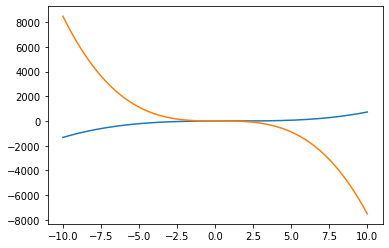

In [111]:
plt.plot(x, cubic.forward(x))

In [112]:
cubic.forward(x).shape

TensorShape([500, 2])

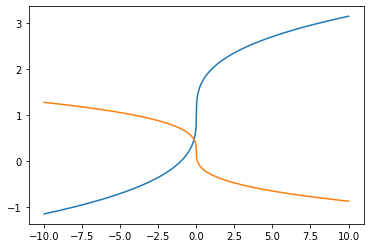

In [113]:
plt.plot(x, cubic.inverse(x))

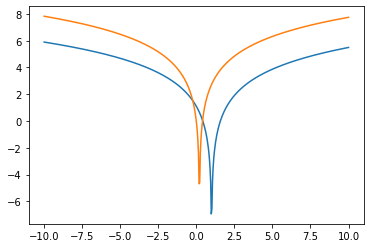

In [114]:
plt.plot(x, cubic.forward_log_det_jacobian(x, event_ndims=0))

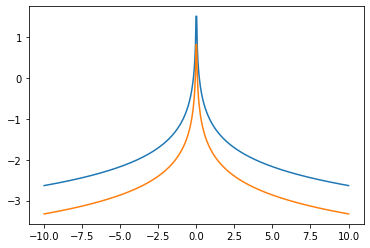

In [115]:
plt.plot(x, cubic.inverse_log_det_jacobian(x, event_ndims=0))

# TransformedDistribution and plots

In [2]:
tfp.__version__

'0.16.0'

In [2]:
from tensorflow_probability.python.internal import parameter_properties
#
# Define a new bijector: Cubic
class Cubic_v2(tfb.Bijector):

    def __init__(self, a, b, validate_args=False, name='Cubic'):
        parameters = dict(locals())   # <-- new
        self._a = tf.convert_to_tensor(a, dtype_hint=tf.float32, name='a')
        self._b = tf.convert_to_tensor(b, dtype_hint=tf.float32, name='b')
        if validate_args:
            assert tf.reduce_mean(tf.cast(tf.math.greater_equal(tf.abs(self._a), 1e-5), tf.float32)) == 1.0
            assert tf.reduce_mean(tf.cast(tf.math.greater_equal(tf.abs(self._b), 1e-5), tf.float32)) == 1.0
        super(Cubic_v2, self).__init__(
            validate_args=validate_args,
             forward_min_event_ndims=0,
             parameters=parameters,   # <-- new
             name=name)

    def get_params(self):
        return self.parameters

    @classmethod
    def _parameter_properties(cls, dtype):   # <-- new
      return dict(a=parameter_properties.ParameterProperties(),
                  b=parameter_properties.ParameterProperties())

    def _forward(self, x):
        x = tf.cast(x, tf.float32)
        return tf.pow(self._a * x + self._b, 3)

    def _inverse(self, y):
        y = tf.cast(y, tf.float32)
        return (tf.math.sign(y) * tf.pow(tf.abs(y), 1/3) - self._b) / self._a

    def _forward_log_det_jacobian(self, x):
        x = tf.cast(x, tf.float32)
        return tf.math.log(3. * tf.abs(self._a)) + 2. * tf.math.log(tf.abs(self._a * x + self._b))

In [4]:
 # Cubic bijector
cubic = Cubic_v2([1.0, -2.0], [-1.0, 0.4], validate_args=True)
cubic

2022-05-05 12:15:33.466617: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-05 12:15:33.466997: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 12:15:33.467327: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 12:15:33.467587: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

<tfp.bijectors.Cubic_v2 'Cubic' batch_shape=[2] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>

In [5]:
cubic.experimental_batch_shape()

TensorShape([2])

In [6]:
cubic.get_params()

{'a': [1.0, -2.0], 'b': [-1.0, 0.4], 'validate_args': True, 'name': 'Cubic'}

In [3]:
# type(Cubic_v2._parameter_properties(None)['a'])
Cubic_v2._parameter_properties(None)

{'a': ParameterProperties(event_ndims=0, event_ndims_tensor=0, shape_fn=<function ParameterProperties.<lambda> at 0x7f81c6d90160>, default_constraining_bijector_fn=<function _default_constraining_bijector_fn at 0x7f81c6d8bb80>, is_preferred=True, is_tensor=True, specifies_shape=False),
 'b': ParameterProperties(event_ndims=0, event_ndims_tensor=0, shape_fn=<function ParameterProperties.<lambda> at 0x7f81c6d90160>, default_constraining_bijector_fn=<function _default_constraining_bijector_fn at 0x7f81c6d8bb80>, is_preferred=True, is_tensor=True, specifies_shape=False)}

 Cubic bijector
cubic = Cubic([1.0, -2.0], [-1.0, 0.4], validate_args=True)

In [8]:
normal = tfd.Normal(loc=0., scale=1.)
display(normal)
# cubed_normal = tfd.TransformedDistribution(normal, cubic, event_shape=[2])
cubed_normal = tfd.TransformedDistribution(normal, cubic, )
cubed_normal

<tfp.distributions.Normal 'Normal' batch_shape=[] event_shape=[] dtype=float32>

<tfp.distributions._TransformedDistribution 'CubicNormal' batch_shape=[2] event_shape=[] dtype=float32>

In [9]:
# cubic.experimental_batch_shape(x_event_ndims=tf.rank(normal.event_shape))

In [10]:
# Sample cubed_normal
n =1000
g = cubed_normal.sample(n)
display(g)
g.shape

<tf.Tensor: shape=(1000, 2), dtype=float32, numpy=
array([[-2.7032084e+00, -2.0008944e+01],
       [-5.8265312e-05,  2.1414256e+00],
       [-5.6209784e+00,  4.6360178e+00],
       ...,
       [-1.9317460e-01,  5.7188695e-04],
       [-4.6160970e+00, -5.2850485e-01],
       [-6.4068884e-01,  3.3126515e-01]], dtype=float32)>

TensorShape([1000, 2])

In [32]:
cubed_normal.prob(g)

<tf.Tensor: shape=(1000, 2), dtype=float32, numpy=
array([[6.3434601e-02, 2.6827427e-03],
       [5.5745773e+01, 3.6256962e-02],
       [3.1079268e-02, 1.9563949e-02],
       ...,
       [3.6405352e-01, 9.5300913e+00],
       [3.8450237e-02, 8.4743753e-02],
       [1.7723939e-01, 1.3740903e-01]], dtype=float32)>

In [11]:
# # Sample cubed_normal
# n =(1000,2)
# g = cubed_normal.sample(n)
# display(g)
# g.shape

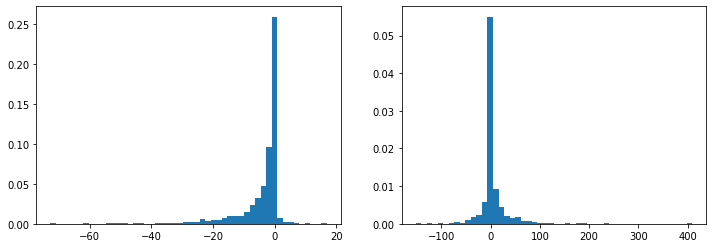

In [12]:
# Plot histograms
plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
plt.hist(g.numpy()[...,0], bins=50, density=True)
plt.subplot(1,2,2)
plt.hist(g.numpy()[...,1], bins=50, density=True)
plt.show()

In [13]:
batch_normal = tfd.TransformedDistribution(
    distribution=tfd.Normal(loc=0., scale=1.),
    bijector=tfb.Shift(shift=[-1., 0., 1.]),
    name='BatchNormalTransformedDistribution')
batch_normal

<tfp.distributions.TransformedDistribution 'BatchNormalTransformedDistribution' batch_shape=[3] event_shape=[] dtype=float32>

In [14]:
batch_normal.sample(10)

<tf.Tensor: shape=(10, 3), dtype=float32, numpy=
array([[ 0.25720274, -0.06280545,  1.5860382 ],
       [ 0.47126198, -0.89730376, -1.091572  ],
       [ 0.11318982,  1.7209656 ,  0.94327974],
       [-1.5695825 , -1.1327053 ,  1.1097294 ],
       [ 0.67787385, -0.04801853,  2.16336   ],
       [-1.1844294 ,  1.6160736 ,  0.69356036],
       [-1.8153564 , -2.1969466 , -0.05530012],
       [-0.39195025, -0.13823397,  0.4465456 ],
       [-0.3971541 , -0.65763324,  1.0050156 ],
       [-0.6097499 , -0.96462816,  1.4122003 ]], dtype=float32)>

In [34]:
xx = np.linspace(-0.5,0.5,100)
yy = np.linspace(-0.5,0.5,100)
X,Y = np.meshgrid(xx,yy)
X.shape, Y.shape

((100, 100), (100, 100))

In [16]:
np.dstack((X, Y)).shape

(100, 100, 2)

In [36]:
np.dstack((X, Y)).shape

(100, 100, 2)

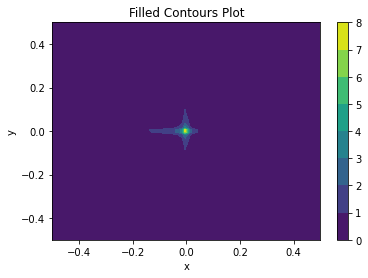

In [46]:
fig, ax = plt.subplots(1,1)
Z = cubed_normal.prob(np.dstack((X, Y)))
cp = ax.contourf(X, Y, tf.multiply(Z[:,:,0], Z[:,:,1]))
fig.colorbar(cp)
ax.set_title('Filled Contours Plot')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

In [59]:
inverse_cubic = tfb.Invert(cubic)
inverse_cubic

<tfp.bijectors._Invert 'invert_Cubic' batch_shape=[2] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=? bijector=<tfp.bijectors.Cubic_v2 'Cubic' batch_shape=[2] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>>

In [60]:
inv_cubed_normal = inverse_cubic(normal)
inv_cubed_normal

<tfp.distributions._TransformedDistribution 'invert_CubicNormal' batch_shape=[2] event_shape=[] dtype=float32>

In [61]:
n = 1000
g = inv_cubed_normal.sample(n)
g.shape

TensorShape([1000, 2])

In [62]:
g

<tf.Tensor: shape=(1000, 2), dtype=float32, numpy=
array([[ 1.0706118 ,  0.7054279 ],
       [ 1.8551424 , -0.35936964],
       [ 2.063249  , -0.14390399],
       ...,
       [ 1.7576418 ,  0.56869817],
       [ 1.7630708 ,  0.71758515],
       [ 2.1540918 , -0.29878265]], dtype=float32)>

# Training the bijector

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
import numpy as np
import matplotlib.pyplot as plt

gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)



2022-05-06 15:54:03.750993: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 15:54:03.776366: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 15:54:03.777109: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


The Cubic_v3

In [2]:
from tensorflow_probability.python.internal import parameter_properties
from tensorflow_probability.python.internal import tensor_util
#
# Define a new bijector: Cubic
class Cubic_v3(tfb.Bijector):

    def __init__(self, a, b, validate_args=False, name='Cubic'):
        parameters = dict(locals())   # <-- new
        # self._a = tf.convert_to_tensor(a, dtype_hint=tf.float32, name='a')
        # self._b = tf.convert_to_tensor(b, dtype_hint=tf.float32, name='b')
        self._a = tensor_util.convert_nonref_to_tensor(a, dtype_hint=tf.float32, name='a')
        self._b = tensor_util.convert_nonref_to_tensor(b, dtype_hint=tf.float32, name='b')

        if validate_args:
            assert tf.reduce_mean(tf.cast(tf.math.greater_equal(tf.abs(self._a), 1e-5), tf.float32)) == 1.0
            assert tf.reduce_mean(tf.cast(tf.math.greater_equal(tf.abs(self._b), 1e-5), tf.float32)) == 1.0
        super(Cubic_v3, self).__init__(
            validate_args=validate_args,
             forward_min_event_ndims=0,
             parameters=parameters,   # <-- new
             name=name)

    def get_params(self):
        return self.parameters

    @classmethod
    def _parameter_properties(cls, dtype):   # <-- new
      return dict(a=parameter_properties.ParameterProperties(),
                  b=parameter_properties.ParameterProperties())

    def _forward(self, x):
        x = tf.cast(x, tf.float32)
        return tf.pow(self._a * x + self._b, 3)

    def _inverse(self, y):
        y = tf.cast(y, tf.float32)
        return (tf.math.sign(y) * tf.pow(tf.abs(y), 1/3) - self._b) / self._a

    def _forward_log_det_jacobian(self, x):
        x = tf.cast(x, tf.float32)
        return tf.math.log(3. * tf.abs(self._a)) + 2. * tf.math.log(tf.abs(self._a * x + self._b))

The target distribution
We also obtain training and validation datasets from it

In [3]:
# Create a mixture of four Gaussians
probs = [0.45, 0.55]
mix_gauss = tfd.Mixture(
    cat=tfd.Categorical(probs=probs),
    components=[
        tfd.Normal(loc=2.3, scale=0.4),
        tfd.Normal(loc=-0.8, scale=0.4)
    ]
)

mix_gauss

2022-05-06 15:54:03.804186: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-06 15:54:03.804681: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 15:54:03.805167: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 15:54:03.805559: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

<tfp.distributions.Mixture 'Mixture' batch_shape=[] event_shape=[] dtype=float32>

In [4]:
# Create the dataset
x_train = mix_gauss.sample(10000)
display(x_train.shape)
display(x_train)
x_train = tf.data.Dataset.from_tensor_slices(x_train)
x_train = x_train.batch(128)

x_valid = mix_gauss.sample(1000)
x_valid = tf.data.Dataset.from_tensor_slices(x_valid)
x_valid = x_valid.batch(128)

print(x_train.element_spec)
print(x_valid.element_spec)

TensorShape([10000])

<tf.Tensor: shape=(10000,), dtype=float32, numpy=
array([-1.2064145,  3.3550634, -0.3987275, ...,  2.6973464,  2.376956 ,
       -0.7583362], dtype=float32)>

TensorSpec(shape=(None,), dtype=tf.float32, name=None)
TensorSpec(shape=(None,), dtype=tf.float32, name=None)


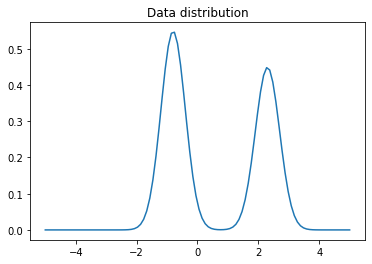

In [5]:
# Plot the data distribution
x = np.linspace(-5,5,100)
plt.plot(x, mix_gauss.prob(x))
plt.title('Data distribution')
plt.show()

Make a trainable bijector

In [6]:
# Make a trainable bijector
trainable_inv_cubic = tfb.Invert(
    Cubic_v3(
        tf.Variable(0.25, trainable=True, name='a'),
        tf.Variable(-0.1, trainable=True, name='b')
    )
)
display(trainable_inv_cubic)
trainable_inv_cubic.trainable_variables

<tfp.bijectors._Invert 'invert_Cubic' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=? bijector=<tfp.bijectors.Cubic_v3 'Cubic' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>>

2022-05-06 15:54:06.037616: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


(<tf.Variable 'a:0' shape=() dtype=float32, numpy=0.25>,
 <tf.Variable 'b:0' shape=() dtype=float32, numpy=-0.1>)

Make a trainable transformed distribution

In [7]:
# Make a trainable transformed distribution
normal = tfd.Normal(loc=0., scale=1.)
trainable_dist = tfd.TransformedDistribution(normal, trainable_inv_cubic)
trainable_dist

<tfp.distributions._TransformedDistribution 'invert_CubicNormal' batch_shape=[] event_shape=[] dtype=float32>

In [8]:
display(trainable_dist.trainable_variables)
# display(trainable_dist.variables)

(<tf.Variable 'a:0' shape=() dtype=float32, numpy=0.25>,
 <tf.Variable 'b:0' shape=() dtype=float32, numpy=-0.1>)

Plot the data and learned distribution at this point

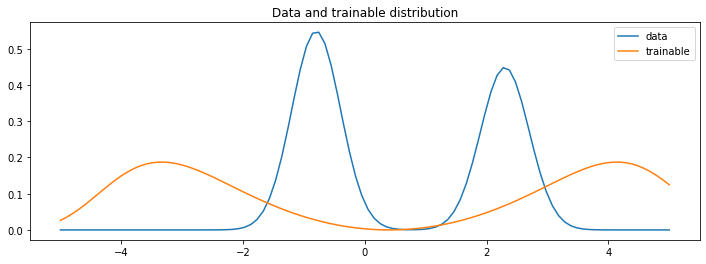

In [9]:
# Plot the data and learned distribution
x = np.linspace(-5,5,100)
plt.figure(figsize=(12,4))
plt.plot(x, mix_gauss.prob(x), label='data')
plt.plot(x, trainable_dist.prob(x), label='trainable')
plt.legend()
plt.title('Data and trainable distribution')
plt.show()

In [10]:
# Train the bijector
num_epochs = 10
opt = tf.keras.optimizers.Adam() #learning_rate=0.005
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch}...')
    train_loss = tf.keras.metrics.Mean()
    val_loss = tf.keras.metrics.Mean()

    for train_batch in x_train:
        with tf.GradientTape() as tape:
            tape.watch(trainable_dist.trainable_variables)
            # loss = -trainable_dist.log_prob(train_batch)
            loss = -tf.reduce_mean(trainable_dist.log_prob(train_batch))
            # print('loss', loss.numpy())
            # print('loss', loss.shape, type(loss))

        grads = tape.gradient(loss, trainable_dist.trainable_variables)
        # print('grads', grads)
        opt.apply_gradients(zip(grads, trainable_dist.trainable_variables))

        train_loss(loss)
        # train_loss.__call__()

    train_losses.append(train_loss.result().numpy())
    print(f'Epoch {epoch} train_losses', train_losses[-1])

    # Validation
    for valid_batch in x_valid:
        loss = -trainable_dist.log_prob(valid_batch)
        val_loss(loss)
    valid_losses.append(val_loss.result().numpy())

Epoch 0...
Epoch 0 train_losses 2.856934
Epoch 1...
Epoch 1 train_losses 2.1878839
Epoch 2...
Epoch 2 train_losses 1.7531452
Epoch 3...
Epoch 3 train_losses 1.4816679
Epoch 4...
Epoch 4 train_losses 1.3306818
Epoch 5...
Epoch 5 train_losses 1.2620302
Epoch 6...
Epoch 6 train_losses 1.2372735
Epoch 7...
Epoch 7 train_losses 1.2299296
Epoch 8...
Epoch 8 train_losses 1.2287123
Epoch 9...
Epoch 9 train_losses 1.2285672


Plot the learning curves

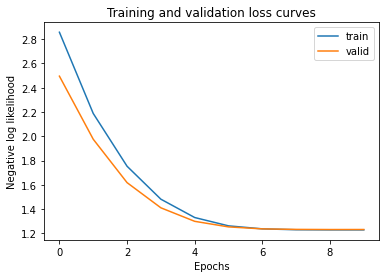

In [11]:
plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Negative log likelihood')
plt.title('Training and validation loss curves')
plt.show()

Plot the data and learned distribution

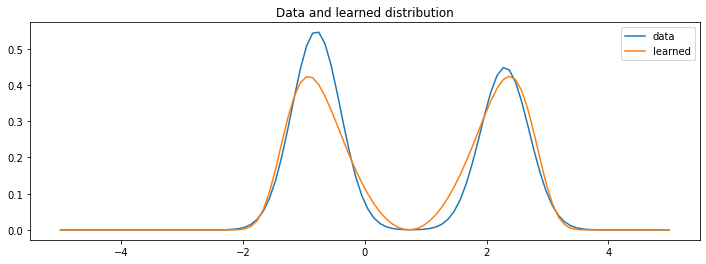

In [14]:
# Plot the data and learned distribution
x = np.linspace(-5,5,100)
plt.figure(figsize=(12,4))
plt.plot(x, mix_gauss.prob(x), label='data')
plt.plot(x, trainable_dist.prob(x), label='learned')
plt.legend()
plt.title('Data and learned distribution')
plt.show()

In [16]:
# Display trainable variables

# trainable_dist.trainable_variables
trainable_inv_cubic.trainable_variables

(<tf.Variable 'a:0' shape=() dtype=float32, numpy=0.5660883>,
 <tf.Variable 'b:0' shape=() dtype=float32, numpy=-0.4108315>)